# GEMS Biotic Risk Usage Example
## Set up an HTTP client using Python's request library
We use a Session object to store our API key and automatically include it in the header for each request.

Note that we have a `api_key.py` file in the Exchange-Notebooks directory. The file contains only the below line.
```
api_key = 'SECRET'
```

In [1]:
from requests import Session
import pandas as pd
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('..')
from api_key import key

pd.options.display.max_colwidth = 500

s = Session()
s.headers.update({'apikey' : key})
pest_url = "https://exchange-1.gems.msi.umn.edu/pest/v2"

## Get description for available layers
To get a list of all avilable layers and retrieve their description, `/senay-eci/layer` endpoint is used.

In [2]:
res = s.get(pest_url+"/senay-eci/layer")
layers = pd.json_normalize(res.json())
layers

,name,units,description,discrete,id
0,bf_ei_s,unitless,Eco-climatic Index. Pest: Busseola fusca. Common Name: maize stalk borer. Category: Insect. Primary Crop Host: maize,False,252
1,bt_ei_s,unitless,Eco-climatic Index. Pest: Bemisia tabaci. Common Name: silverleaf (sweetpotato) whitefly. Category: Insect. Primary Crop Host: cassava,False,253
2,cm_ei_s,unitless,"Eco-climatic Index. Pest: Cicadulina mbila. Common Name: (South African) maize leafhopper. Category: Insect. Primary Crop Host: maize, rice, wheat, oats, barley, rye, finger millet, sorghum, sugarcane, and wild grass species",False,254
3,cp_ei_s,unitless,Eco-climatic Index. Pest: Chilo partellus. Common Name: spotted stalk borer. Category: Insect. Primary Crop Host: maize,False,255
4,cs_ei_s,unitless,Eco-climatic Index. Pest: Cochliobolus sativus. Common Name: spot blotch. Category: Pathogen. Primary Crop Host: wheat,False,256
5,dv_ei_s,unitless,Eco-climatic Index. Pest: Diabrotica virgifera virgifera. Common Name: Western corn rootworm. Category: Insect. Primary Crop Host: maize,False,257
6,ei_ei_s,unitless,Eco-climatic Index. Pest: Eurygaster integriceps. Common Name: sunn pest. Category: Insect. Primary Crop Host: wheat,False,258
7,fg_ei_s,unitless,Eco-climatic Index. Pest: Fusarium graminearum. Common Name: Fusarium head blight (scab). Category: Pathogen. Primary Crop Host: wheat,False,259
8,fw_ei_s,unitless,"Eco-climatic Index. Pest: Frankliniella williamsi. Common Name: corn thrips. Category: Insect. Primary Crop Host: maize, cassava",False,260
9,ho_ei_s,unitless,"Eco-climatic Index. Pest: Hirschmanniella oryzae. Common Name: rice root nematode (RRN). Category: Nematode. Primary Crop Host: rice, maize, sugarcane, wheat, grasses, and sedges",False,261


## List available objects under all layers
To search all available objects, an area of interest must be defined as a bounding box.

In [3]:
area_of_interest = "0,47,6,52"
params = {
    "bbox": area_of_interest,
    "limit": 30
}
res = s.get(pest_url+"/senay-eci/object/search", params=params)
df = pd.json_normalize(res.json())
df.head()

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,187318,1,"[{'begin': None, 'end': None}]",None,None,bf_ei_s,unitless,Eco-climatic Index. Pest: Busseola fusca. Common Name: maize stalk borer. Category: Insect. Primary Crop Host: maize,252
1,187319,1,"[{'begin': None, 'end': None}]",None,None,bt_ei_s,unitless,Eco-climatic Index. Pest: Bemisia tabaci. Common Name: silverleaf (sweetpotato) whitefly. Category: Insect. Primary Crop Host: cassava,253
2,187320,1,"[{'begin': None, 'end': None}]",None,None,cm_ei_s,unitless,"Eco-climatic Index. Pest: Cicadulina mbila. Common Name: (South African) maize leafhopper. Category: Insect. Primary Crop Host: maize, rice, wheat, oats, barley, rye, finger millet, sorghum, sugarcane, and wild grass species",254
3,187321,1,"[{'begin': None, 'end': None}]",None,None,cp_ei_s,unitless,Eco-climatic Index. Pest: Chilo partellus. Common Name: spotted stalk borer. Category: Insect. Primary Crop Host: maize,255
4,187322,1,"[{'begin': None, 'end': None}]",None,None,cs_ei_s,unitless,Eco-climatic Index. Pest: Cochliobolus sativus. Common Name: spot blotch. Category: Pathogen. Primary Crop Host: wheat,256


## Access and vizualize raster data
Example below illustrates how to access and visualize raster data while keeping the returned files in memory.  
**The results illustrate spatial distribution and Eco-Climatic Index values of selected pests affecting production of maize  in Africa.**

/tmp/ipykernel_23914/3859686912.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


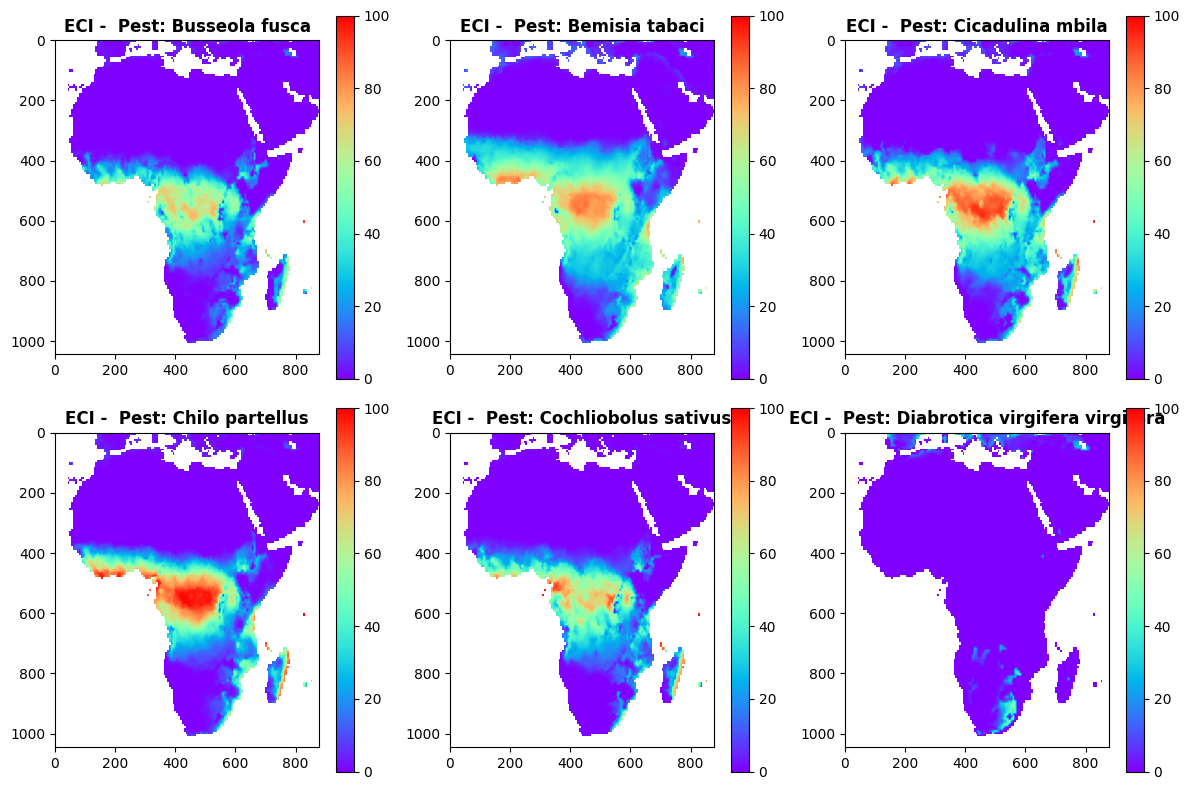

In [6]:
object_ids_of_interest = [187318, 187319, 187320, 187321, 187322, 187323]
area_of_interest = "-22,-38,60,42"
params = {
    "bbox": area_of_interest
}

rows = 2
cols = 3
axes = []
fig = plt.figure(figsize=(12,8))

for index, object_id in zip(range(rows*cols), object_ids_of_interest):
    res = s.get(pest_url + f"/senay-eci/object/{object_id}")
    layer_id =  res.json()["layer_id"]
    res = s.get(pest_url + f"/senay-eci/layer/{layer_id}")
    meta =  res.json()["description"].split(".")[1]
    res = s.get(pest_url + f"/senay-eci/object/{object_id}/raster", params=params)
    raster = res.content
    with rasterio.MemoryFile(raster) as memfile:
        with memfile.open() as dataset:
            data = dataset.read(1)
            data = data.astype("float32")
            data[data==dataset.nodata]=np.nan
            axes.append( fig.add_subplot(rows, cols, index+1))
            subplot_title=(f"ECI - {meta}")
            axes[-1].set_title(subplot_title, weight="bold")
            plt.imshow(data, interpolation="none", cmap="rainbow")
            plt.clim(0,100)
            plt.colorbar()
            plt.tight_layout()

## Sample Point Data
The following example illustrates how to get Eco-Climatic Index values for points from their geographic coordinates and combine the results in a tabular format.

In [12]:
points = {
    "name":["point1", "point2", "point3", "point4", "point5"], 
    "lat":[29.26, -2.4, 45.97, 8.11, 34.56], 
    "lon":[-98.54, 25.4, 21.38, -63.2, 81.22]
}

df = pd.DataFrame(points)
start_obj_id = 187318
for object_id in range(start_obj_id, start_obj_id + 10):
    for index,row in df.iterrows():
        params = {
            "lat" : row["lat"],
            "lon" : row["lon"]
        }
        res = s.get(pest_url + f"/senay-eci/object/{object_id}/point", params=params)
        df.loc[index, str(object_id)] = res.json()["value"]
df

,name,lat,lon,187318,187319,187320,187321,187322,187323,187324,187325,187326,187327
0,point1,29.26,-98.54,12.0,24.0,14.0,10.0,0.0,0.0,8.0,18.0,0.0,11.0
1,point2,-2.40,25.40,62.0,79.0,88.0,90.0,59.0,0.0,0.0,48.0,60.0,85.0
2,point3,45.97,21.38,2.0,0.0,0.0,2.0,0.0,15.0,0.0,16.0,1.0,0.0
3,point4,8.11,-63.20,12.0,59.0,29.0,49.0,19.0,0.0,0.0,19.0,4.0,56.0
4,point5,34.56,81.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Get summary statistics
`/stats` endpoint allows to spatially summarize the values of a raster within the area of interest defined as a bounding box.

In [15]:
area_of_interest = "-68,-19,-50,-8"
params = {
    "bbox": area_of_interest
}
dfs=[]
start_obj_id = 187318
for object_id in range(start_obj_id, start_obj_id + 10):
    res = s.get(pest_url + f"/senay-eci/object/{object_id}/stats", params=params)    
    res.json()
    df = pd.json_normalize(res.json())
    df.index = [f"Object {object_id}"]
    dfs.append(df)
stats = pd.concat(dfs)
stats

,count,sum,mean,stddev,min,max
Object 187318,28992,609432.0,21.020695,12.518986,0.0,62.0
Object 187319,28992,1408433.0,48.580057,15.215949,0.0,74.0
Object 187320,28992,1070338.0,36.918391,14.911162,0.0,75.0
Object 187321,28992,1572917.0,54.253484,15.631492,0.0,85.0
Object 187322,28992,865260.0,29.844785,12.294696,0.0,69.0
Object 187323,28992,5254.0,0.181222,1.665264,0.0,35.0
Object 187324,28992,0.0,0.000000,0.000000,0.0,0.0
Object 187325,28992,726354.0,25.053601,8.835593,0.0,65.0
Object 187326,28992,382125.0,13.180360,11.639146,0.0,58.0
Object 187327,28992,1684668.0,58.108030,14.088917,0.0,88.0


An area of interest can also be defined with a more detailed geometry as a GeoJSON; in this case raster data can be summarized with `post` request.

In [18]:
area_of_interest = {
    "type": "Polygon",
    "coordinates":   [
          [
            [
              72.82503422249329,
              27.80005276605614
            ],
            [
              78.50199140302476,
              22.08630177665971
            ],
            [
              87.51326132330672,
              24.21630664082737
            ],
            [
              89.5795001212486,
              28.98574780072441
            ],
            [
              82.58612314108473,
              32.28295389071019
            ],
            [
              73.54970640926146,
              32.433743848990275
            ],
            [
              72.82503422249329,
              27.80005276605614
            ]
          ]
        ]
}

dfs=[]
start_obj_id = 187318
for object_id in range(start_obj_id, start_obj_id + 10):
    res = s.post(pest_url+ f'/senay-eci/object/{object_id}/stats', json=area_of_interest) 
    res.json()
    df = pd.json_normalize(res.json())
    df.index = [f"Object {object_id}"]
    dfs.append(df)
stats = pd.concat(dfs)
stats

,count,sum,mean,stddev,min,max
Object 187318,16595,39566.0,2.384212,4.212810,0.0,33.0
Object 187319,16595,269804.0,16.258150,11.215160,0.0,40.0
Object 187320,16595,70397.0,4.242061,7.368862,0.0,45.0
Object 187321,16595,104841.0,6.317626,9.098950,0.0,45.0
Object 187322,16595,60089.0,3.620910,5.610186,0.0,38.0
Object 187323,16595,19148.0,1.153842,4.418143,0.0,37.0
Object 187324,16595,0.0,0.000000,0.000000,0.0,0.0
Object 187325,16595,57352.0,3.455981,8.516530,0.0,55.0
Object 187326,16595,10043.0,0.605182,2.440335,0.0,25.0
Object 187327,16595,160314.0,9.660380,13.027673,0.0,48.0


## Calculate multiple pest co-occurrence
Multiple pest risk layers can be combined to produce estimates on the co-occurrence of pests using the examples below. To create a co-occurence estimate, provide a dictionary where keys are the object_ids of pest layers of interest and the values are a threshold for when a risk index is considered occurrence (e.g., all values greater than 0 or greater than 5). The co-occurrence estimate is the count of all pest layers that exceed their threshold at a given point or cell. 

### Calculating pest co-occurrence for a point

In [19]:
# Dictionary keys are object_ids for pest layers of interest
# Key values are threshold for what level of risk index is considered occurrence,
# and is defined by the user. Common values are 0 or 5. 
pest_threshold = {
    1: 5,
    3: 5,
    4: 0,
    15: 20,
    20: 5,
    21: 0
}

# Point of interest
params = {
    'lat': 29.26,
    'lon': -98.54
}

# Initialize the co-occurence count
co_occurrence = 0

for object_id in pest_threshold.keys():
    res = s.get(pest_url + f"/senay-eci/object/{object_id}/point", params=params)
    if res.json()['value'] > pest_threshold[object_id]:
        co_occurrence += 1  # If the value for a pest risk index is greater than the threshold defined for it, add one.
print('Pest co-occurrence count', co_occurrence)

KeyError: 'value'

### Calculating pest co-occurrence for arrays/rasters

In [ ]:
# Define the bounding box for the rasters
params = {"bbox": "-22,-38,60,42"}

# Dictionary keys are object_ids for pest layers of interest
# Key values are threshold for what level of risk index is considered occurrence,
# and is defined by the user. Common values are 0 or 5. 
pest_threshold = {
    1: 5,
    3: 5,
    4: 0,
    15: 20,
    20: 5,
    21: 0
}

# Initialize an array to store occurrence counts
occurrence_count_array = np.array([0])

rows = 2
cols = 3
axes = []
fig = plt.figure(figsize=(12, 8))

for index, object_id in zip(range(rows*cols), pest_threshold.keys()):
    res = s.get(pest_url + f"/senay-eci/object/{object_id}")
    layer_id = res.json()["layer"]
    res = s.get(pest_url + f"/senay-eci/layer/{layer_id}")
    meta = res.json()["description"].split(".")[1]
    res = s.get(pest_url + f"/senay-eci/object/{object_id}/raster", params=params)
    raster = res.content
    with rasterio.MemoryFile(raster) as memfile:
        with memfile.open() as dataset:
            data = dataset.read(1)
            data = data.astype("float32")
            data[data == dataset.nodata] = np.nan

            # Create a new array where the values that are greater than the threshold are set to 1 and all others 0.
            binary_array = np.where(data > pest_threshold[object_id], 1, 0)
            # Add the binary array to the occurrence count array
            occurrence_count_array = occurrence_count_array + binary_array

            axes.append(fig.add_subplot(rows, cols, index+1))
            subplot_title = f"ECI - {meta}"
            axes[-1].set_title(subplot_title, weight="bold")
            plt.imshow(binary_array, interpolation="none", cmap="rainbow")
            plt.clim(0, 6)
            plt.colorbar()
            plt.tight_layout()

# Display the binary occurrence maps
plt.show()

# Display the co-occurrence count map
plt.imshow(occurrence_count_array, interpolation="none", cmap="rainbow")
plt.clim(0, 6)
plt.colorbar()
plt.title('Co-occurrence count')
plt.show()

### Calculating pest co-occurrence for a polygon
The recommended way to calculate an average value for pest co-occurrence for a polygon is to first create an array of co-occurrence count, and then to use a package such as raster stats to calculate the average for the cells within an area of interst.

In [ ]:
# New imports needed for this calculating
from rasterstats import zonal_stats
import geopandas as gpd

# Define the bounding box for the source rasters
params = {"bbox": "-22,-38,60,42"}

# Define the area of interest to calculate zonal statistics for
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              19.541497959106096,
              8.7807914268802
            ],
            [
              16.418734291239133,
              7.695390640904606
            ],
            [
              15.882924975572394,
              2.025236078865319
            ],
            [
              21.52566683118269,
              1.5482643054285603
            ],
            [
              28.183728177869313,
              6.305938137120677
            ],
            [
              24.810480392002432,
              8.698946846228068
            ],
            [
              19.541497959106096,
              8.7807914268802
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# Convert the geoJSON object in a geodataframe, define the CRS as WGS1984 (EPSG 4326)
# and reproject to match GEMS data projection of EASE v2 (EPSG 6933)
aoi = gpd.GeoDataFrame.from_features(aoi['features'])
aoi = aoi.set_crs(4326)
aoi = aoi.to_crs(6933)

# Dictionary keys are object_ids for pest layers of interest
# Key values are threshold for what level of risk index is considered occurrence,
# and is defined by the user. Common values are 0 or 5.
pest_threshold = {
    1: 5,
    3: 5,
    4: 0,
    15: 20,
    20: 5,
    21: 0
}
# Initialize an array to store occurrence counts
occurrence_count_array = np.array([0])

for object_id in pest_threshold.keys():
    res = s.get(pest_url + f"/senay-eci/object/{object_id}/raster", params=params)
    raster = res.content
    with rasterio.MemoryFile(raster) as memfile:
        with memfile.open() as dataset:
            # Get the geotransform and nodata properties from the source raster datasets
            geotransform = dataset.transform
            nodata = dataset.nodata
            data = dataset.read(1)
            data = data.astype("float32")
            data[data == dataset.nodata] = np.nan

            # Create binary pest occurrence arrays and add them to occurrence count array
            binary_array = np.where(data > pest_threshold[object_id], 1, 0)
            occurrence_count_array = occurrence_count_array + binary_array

# Use the source raster datasets geoproperties to define spatial properties of occurrence count array
# Then calculate zonal statistics using the rasterstats package
zs = zonal_stats(aoi, occurrence_count_array, affine=geotransform, nodata=nodata)
print(zs)